# Part 4 - Peak Identification

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

data = np.loadtxt('ZnO.xye')

def fig_setup(figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    return fig, ax

Recreating the rolling_average function from Part 3, and using it to smooth out peaks in the background noise of the data:

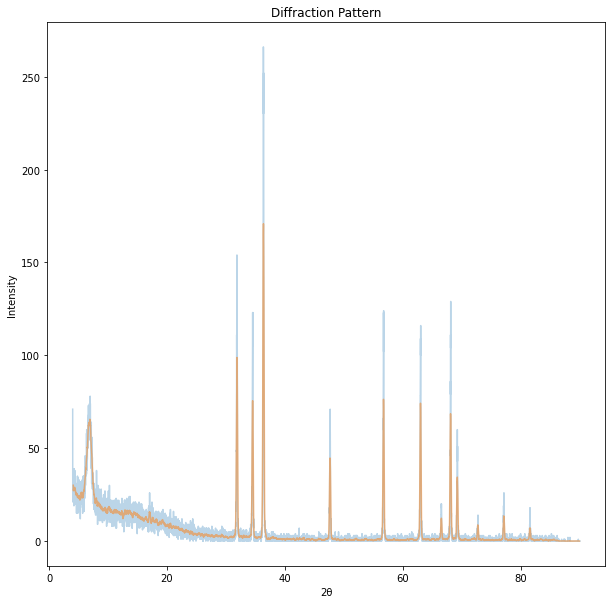

<Figure size 432x288 with 0 Axes>

In [3]:
def rolling_average(data, n):
    moving_average = []
    new_x = []
    x_max = []
    for i in range(0, (len(data[:,0]) - n + 1)):
        window = data[:,1][i : i + n]
        x_window = data[:,0][i : i + n]
        
        max_index = np.searchsorted(window, max(window)) # index in window of maximum y in unaveraged data
        x = x_window[max_index-1]
        x_max.append(x)
        
        window_average = sum(window) / n
        moving_average.append(window_average)
        
        new_x.append(data[:,0][int(i+(n/2))])
        
    return (new_x, moving_average, x_max)

fig, ax = fig_setup()
plt.plot(data[:,0], data[:,1], alpha = 0.3)
plt.plot(rolling_average(data, 20)[0], rolling_average(data, 20)[1], alpha = 0.5)
plt.xlabel('2θ')
plt.ylabel('Intensity')
plt.title('Diffraction Pattern')
plt.show()
plt.clf()

peak_identifier function utilises the rolling_average function to avoid misidentifying peaks in the noise:

In [4]:
def peak_identifier(data, n, height, threshold, distance, prominence):
    y = rolling_average(data, n)[1]
    peaks = find_peaks(y, height=height, threshold=threshold, distance=distance, prominence=prominence)[0]
    y_peaks = []
    x_peaks = []
    
    for i in peaks:
        x_peaks.append(rolling_average(data, n)[0][i])
    for x in x_peaks:
        index = np.searchsorted(data[:,0], x)
        y_actual = data[:,1][index]
        y_peaks.append(y_actual)
        
    return x_peaks, y_peaks

plot_peaks plots and labels the peaks identified using the peak_identifier function:

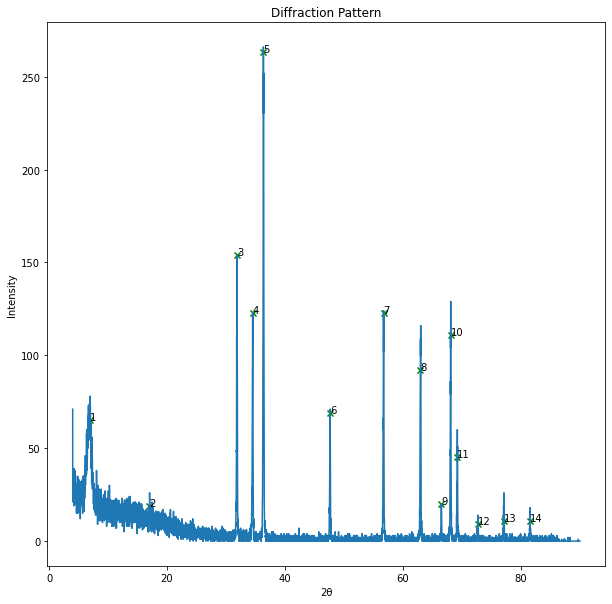

<Figure size 432x288 with 0 Axes>

In [5]:
def plot_peaks(data, n, height, threshold, distance, prominence):
    peaks = peak_identifier(data, n, height, threshold, distance, prominence)
    fig, ax = fig_setup()
    plt.plot(data[:,0], data[:,1])
    plt.scatter(peaks[0], peaks[1], marker='x', color='g')
    plt.xlabel('2θ')
    plt.ylabel('Intensity')
    plt.title('Diffraction Pattern')
    
    counter = 1
    for num in range(0, len(peaks[0])):
        x = peaks[0][num]
        y = peaks[1][num]
        plt.text(x, y, str(counter))
        counter += 1

    plt.show()
    plt.clf()
    
data = np.loadtxt('ZnO.xye')
plot_peaks(data, n = 20, height = 5, threshold = 0, distance = 1, prominence = 5)

Linear background function taken from Part 2b:

In [6]:
def lnr_bgd(data, xmin=data[:,0][0], xmax=data[:,0][len(data[:,0])-1], width=1.5, peak_width=1.0):
    index_xmin = np.searchsorted(data[:,0], xmin)
    index_xmax = np.searchsorted(data[:,0], xmax)
    
    sliced_data_x = data[:,0][index_xmin:(index_xmax + 1)]
    sliced_data_y = data[:,1][index_xmin:(index_xmax + 1)]
    
    max_index = np.argmax(sliced_data_y)
    
    lower_bound_x = sliced_data_x[max_index] - (width/2)
    upper_bound_x = sliced_data_x[max_index] + (width/2)
    
    lower_bound_i = np.searchsorted(sliced_data_x, lower_bound_x)
    upper_bound_i = np.searchsorted(sliced_data_x, upper_bound_x)
    
    peak_start_x = sliced_data_x[max_index] - (peak_width/2)
    peak_end_x = sliced_data_x[max_index] + (peak_width/2)
    
    peak_start_i = np.searchsorted(sliced_data_x, peak_start_x)
    peak_end_i = np.searchsorted(sliced_data_x, peak_end_x)
    
    x_lower = sliced_data_x[lower_bound_i:(peak_start_i + 1)]
    x_upper = sliced_data_x[peak_end_i:(upper_bound_i + 1)]
    
    y_lower = sliced_data_y[lower_bound_i:(peak_start_i + 1)]
    y_upper = sliced_data_y[peak_end_i:(upper_bound_i + 1)]
    
    combined_x = np.concatenate((x_lower, x_upper))
    combined_y = np.concatenate((y_lower, y_upper))
    
    nan_indexes = []                             # indicies of not null values
    for i in range(0, len(combined_y), 1):
        if np.isnan(combined_y[i]) == False:
            nan_indexes.append(i)
    
    clean_x = []                                 # x data without null values
    for i in nan_indexes:
        clean_x.append(combined_x[i])
    
    clean_y = combined_y[np.logical_not(np.isnan(combined_y))]    # y data without null values
    
    counter = 0
    for i in clean_x:
        if np.isfinite(i) == False:
            counter += 1
    #print(counter)
    
    coef = np.polyfit(clean_x, clean_y, 1)
    y_line = coef[1] + coef[0] * pow(data[:,0], 1)
    
    #plt.plot(data[:,0], data[:,1])
    #plt.plot(data[:,0], y_line, 'r')
    #ax.set_xlim(data[:,0][index_xmin], data[:,0][index_xmax])
    #plt.legend(['Diffraction Data', 'Linear Background'])
    #plt.xlabel('2θ')
    #plt.ylabel('Intensity')
    #plt.title('Diffraction Pattern')
    #plt.show()
    #plt.clf()
    
    return y_line, peak_start_i, peak_end_i

position_area finds the linear background-corrected areas of each peak identified by the peak_identifier function and sorts them by x-position or area:

In [7]:
def position_area(data, n, height, threshold, distance, prominence, sort_by, width = 1.5, peak_width = 1.0):
    x_peaks = peak_identifier(data=data, n=n, height=height, threshold=threshold, distance=distance, prominence=prominence)[0]
    y_line = lnr_bgd(data, width = width, peak_width = peak_width)[0]
    
    corrected_areas = []
    for peak in x_peaks:
        
        x_lower = peak - (peak_width/2)
        x_upper = peak + (peak_width/2)  
        
        index_x_lower = np.searchsorted(data[:,0], x_lower)
        index_x_upper = np.searchsorted(data[:,0], x_upper)
    
        x = data[:,0][index_x_lower:(index_x_upper+1)]
        y = data[:,1][index_x_lower:(index_x_upper+1)]
        area_peak = np.trapz(y, x, dx = 0.1)
    
        y_bgd = y_line[index_x_lower:(index_x_upper+1)]
        area_bgd = np.trapz(y_bgd, x, dx = 0.1)
        
        corrected_area = area_peak - area_bgd
        corrected_areas.append(corrected_area)
        
    dict_x_sorted = dict(zip(x_peaks, corrected_areas))
        
    if sort_by == 'area':
        # sorting by area
        area_sorted = sorted(dict_x_sorted.items(), key=lambda x:x[1])
        res = [(sub[1], sub[0]) for sub in area_sorted]
        dict_area_sorted = dict(res)
        return dict_area_sorted
    elif sort_by == 'x_position':
        # sorting by x_position
        return dict_x_sorted
    else:
        print('Error incorrect sort_by arguement choose from area or x_position')
    
#print(position_area(data, n = 20, height = 5, threshold = 0, distance = 1, prominence = 5, sort_by = 'area'))
#print(position_area(data, n = 20, height = 5, threshold = 0, distance = 1, prominence = 5, sort_by = 'x_position'))
#print(position_area(data, n = 20, height = 5, threshold = 0, distance = 1, prominence = 5, sort_by = 'x'))

plotting function plots the data and labels the peaks in order numerically either by x position or by area:

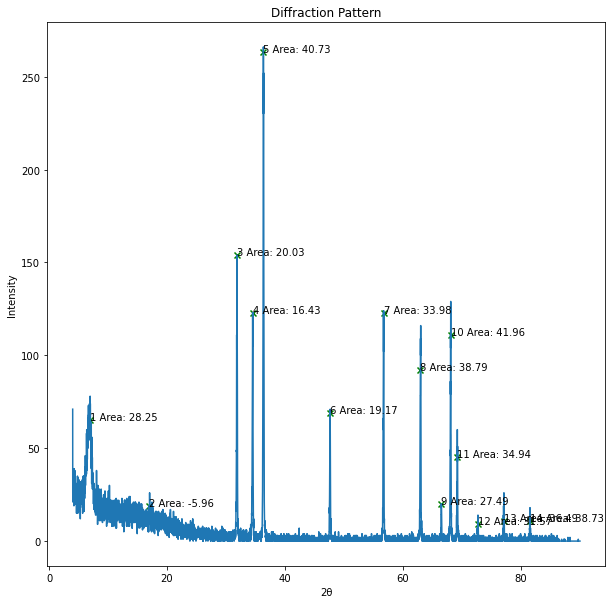

<Figure size 432x288 with 0 Axes>

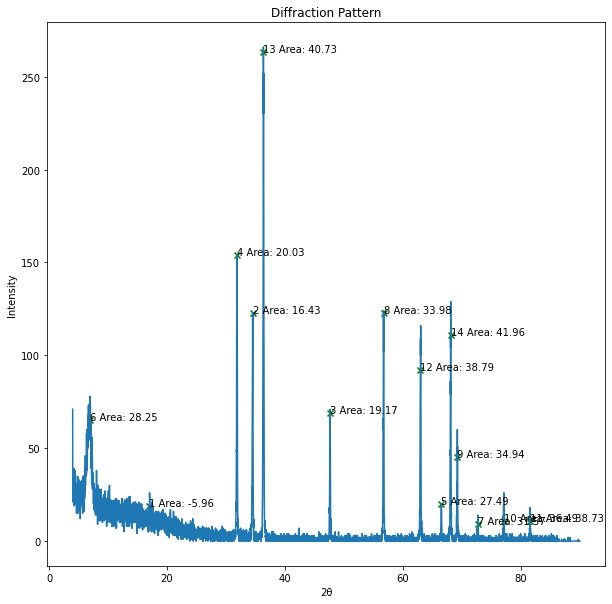

<Figure size 432x288 with 0 Axes>

In [8]:
def plotting(data, n, height, threshold, distance, prominence, sort_by, width = 1.5, peak_width = 1.0):
    dict = position_area(data = data, n=n, height = height, threshold = threshold, distance = distance, prominence = prominence, sort_by = sort_by, width = width, peak_width = peak_width)
    
    fig, ax = fig_setup()
    plt.plot(data[:,0], data[:,1])
    plt.scatter(peak_identifier(data, n, height, threshold, distance, prominence)[0], peak_identifier(data, n, height, threshold, distance, prominence)[1], marker='x', color='g')
    
    if sort_by == 'area':
        counter = 1
        for area, x_peak in dict.items():
            index = np.searchsorted(peak_identifier(data, n, height, threshold, distance, prominence)[0], x_peak)
            x = x_peak
            y = peak_identifier(data, n, height, threshold, distance, prominence)[1][index]
            plt.text(x, y, str(counter) + ' Area: ' + str(round(area, 2)))
            counter += 1 
    elif sort_by == 'x_position':
        counter = 1
        for x_peak, area in dict.items():
            index = peak_identifier(data, n, height, threshold, distance, prominence)[0].index(x_peak)
            x = x_peak
            y = peak_identifier(data, n, height, threshold, distance, prominence)[1][index]
            plt.text(x, y, str(counter) + ' Area: ' + str(round(area, 2)))
            counter += 1        
    else:
        print('Error incorrect sort_by arguement choose from area or x_position')
    
    plt.xlabel('2θ')
    plt.ylabel('Intensity')
    plt.title('Diffraction Pattern')    
    plt.show()
    plt.clf()

plotting(data, n = 20, height = 5, threshold = 0, distance = 1, prominence = 5, sort_by = 'x_position')
plotting(data, n = 20, height = 5, threshold = 0, distance = 1, prominence = 5, sort_by = 'area')